In [2]:
from configparser import ConfigParser
from langchain.llms import OpenAI
import os

config = ConfigParser()
config.read("../config.ini")
os.environ["OPENAI_API_KEY"] = config["KEY"]["openai_key"]


In [3]:
from autogen import ConversableAgent
from IPython.display import Image
import tempfile

flaml.automl is not available. Please install flaml[automl] to enable AutoML functionalities.


In [4]:
temp_dir = tempfile.TemporaryDirectory()

In [15]:
message_with_code_block = '''This is a message with code block
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0,100,100)
y = np.random.randint(0,100,100)
plt.scatter(x,y)
plt.savefig("scatter.png")
print("Scatter plot saved to scatter.png")
```
This is the end of code message
'''

## Using Local Code Executor

In [6]:
from autogen.coding import LocalCommandLineCodeExecutor

In [7]:
executor = LocalCommandLineCodeExecutor(
        timeout=10,
        work_dir=temp_dir.name
)

In [8]:
code_executor_agent = ConversableAgent(
        "code_executor_agent",
        llm_config=False,
        code_execution_config={"executor": executor},
        human_input_mode="ALWAYS"
)

In [9]:
replay = code_executor_agent.generate_reply(
        messages=[
                {
                        "role":"user",
                        "content":message_with_code_block
                }
        ]
)
print(replay)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



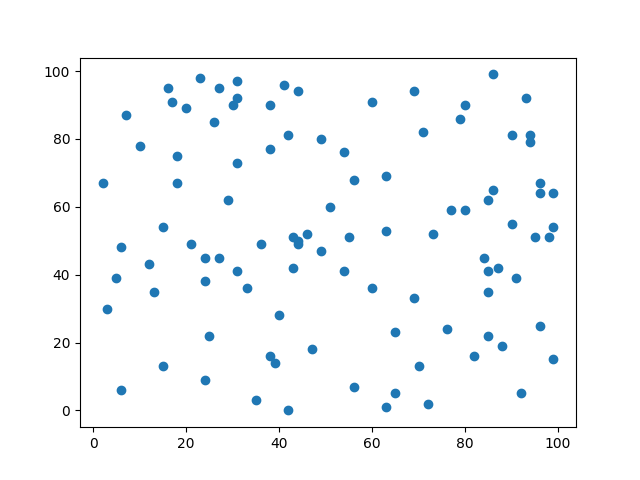

In [10]:
Image(os.path.join(temp_dir.name, "scatter.png"))

## Using Docker Code Executor

In [40]:
message_with_code_block = '''This is a message with code block
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0,100,100)
y = np.random.randint(0,100,100)
plt.scatter(x,y)
plt.savefig("scatter.png")
print("Scatter plot saved to scatter.png")
```
This is the end of code message
'''

In [41]:
from autogen.coding import DockerCommandLineCodeExecutor

In [43]:
executor = DockerCommandLineCodeExecutor(
        image="python:3.12-slim",
        timeout=10,
        work_dir=temp_dir.name
)

In [44]:
code_executor_agent = ConversableAgent(
        "code_executor_agent",
        llm_config= False,
        code_execution_config = {"executor":executor},
        human_input_mode="NEVER"
)

In [45]:
replay = code_executor_agent.generate_reply(
        messages=[
                {
                        "role":"user",
                        "content":message_with_code_block
                }
        ]
)
print(replay)


>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



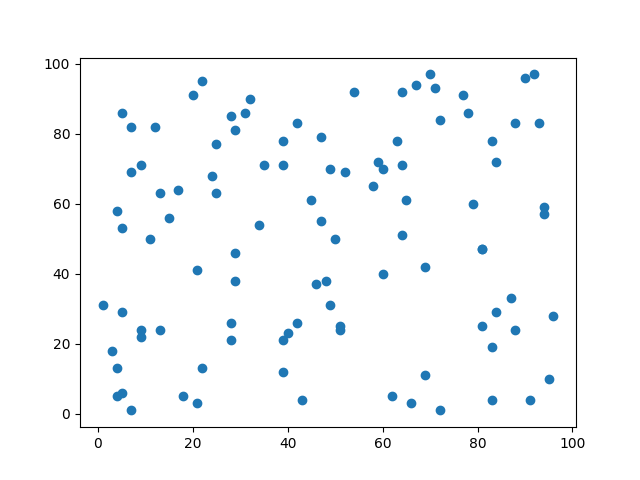

In [46]:
Image(os.path.join(temp_dir.name, "scatter.png"))

In [47]:
!docker ps

CONTAINER ID   IMAGE              COMMAND     CREATED         STATUS         PORTS     NAMES
6ce3566b6d0f   python:3.12-slim   "/bin/sh"   6 minutes ago   Up 6 minutes             autogen-code-exec-82b72dac-9f69-4bf9-9e5b-fb8ec4b15f7e


In [48]:
executor.stop()

In [49]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [50]:
temp_dir.cleanup()

## Code Executor In Conversation

In [51]:
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

In [52]:
temp_dir = tempfile.TemporaryDirectory()

In [53]:
code_writer_agent = ConversableAgent(
    "code_writer_agent",
    system_message=code_writer_system_message,
    llm_config={"config_list": [{"model":"gpt-3.5-turbo", "api_key":os.environ["OPENAI_API_KEY"]}]},
    code_execution_config=False,
)

executor = DockerCommandLineCodeExecutor(
    image="python:3.12-slim",
    timeout=10,
    work_dir=temp_dir.name,
)

In [54]:
code_executor_agent = ConversableAgent(
    "code_executor_agent_docker",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
)

In [55]:
code_executor_agent.initiate_chat(
        code_writer_agent,
        message="Plot a chart of NVDA and TESLA stock price change YTD.",
    )

code_executor_agent_docker (to code_writer_agent):

Plot a chart of NVDA and TESLA stock price change YTD.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent_docker):

# filename: stock_price_plot.py

import yfinance as yf
import matplotlib.pyplot as plt

# Get the historical stock data for NVDA and TSLA
nvda = yf.Ticker("NVDA")
tsla = yf.Ticker("TSLA")

nvda_data = nvda.history(period="YTD")["Close"]
tsla_data = tsla.history(period="YTD")["Close"]

# Plot the stock price change YTD
plt.figure(figsize=(12, 6))
plt.plot(nvda_data, label="NVDA")
plt.plot(tsla_data, label="TSLA")
plt.title("NVDA and TSLA Stock Price Change YTD")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()

--------------------------------------------------------------------------------

>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
code_executor_agent_docker (

ChatResult(chat_id=None, chat_history=[{'content': 'Plot a chart of NVDA and TESLA stock price change YTD.', 'role': 'assistant', 'name': 'code_executor_agent_docker'}, {'content': '# filename: stock_price_plot.py\n\nimport yfinance as yf\nimport matplotlib.pyplot as plt\n\n# Get the historical stock data for NVDA and TSLA\nnvda = yf.Ticker("NVDA")\ntsla = yf.Ticker("TSLA")\n\nnvda_data = nvda.history(period="YTD")["Close"]\ntsla_data = tsla.history(period="YTD")["Close"]\n\n# Plot the stock price change YTD\nplt.figure(figsize=(12, 6))\nplt.plot(nvda_data, label="NVDA")\nplt.plot(tsla_data, label="TSLA")\nplt.title("NVDA and TSLA Stock Price Change YTD")\nplt.xlabel("Date")\nplt.ylabel("Stock Price ($)")\nplt.legend()\nplt.grid(True)\nplt.show()', 'role': 'user', 'name': 'code_writer_agent'}, {'content': '', 'role': 'assistant', 'name': 'code_executor_agent_docker'}, {'content': 'Please execute the Python script provided to plot the chart of NVDA and TSLA stock price change Year-to-Da

In [56]:
!docker ps


CONTAINER ID   IMAGE              COMMAND     CREATED              STATUS              PORTS     NAMES
b29d20173c8c   python:3.12-slim   "/bin/sh"   About a minute ago   Up About a minute             autogen-code-exec-7cd85ea6-eaa4-4659-a836-925bf2668a93


In [57]:
executor.stop()

In [58]:
!docker ps


CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [59]:
temp_dir.cleanup()